# Introducing txtai

[txtai](https://github.com/neuml/txtai) executes machine-learning workflows to transform data and build AI-powered semantic search applications. 

Traditional search systems use keywords to find data. Semantic search applications have an understanding of natural language and identify results that have the same meaning, not necessarily the same keywords.

Backed by state-of-the-art machine learning models, data is transformed into vector representations for search (also known as embeddings). Innovation is happening at a rapid pace, models can understand concepts in documents, audio, images and more.

The following is a summary of key features:

- 🔎 Large-scale similarity search with multiple index backends ([Faiss](https://github.com/facebookresearch/faiss), [Annoy](https://github.com/spotify/annoy), [Hnswlib](https://github.com/nmslib/hnswlib))
- 📄 Create embeddings for text snippets, documents, audio, images and video. Supports transformers and word vectors.
- 💡 Machine-learning pipelines to run extractive question-answering, zero-shot labeling, transcription, translation, summarization and text extraction
- ↪️️ Workflows that join pipelines together to aggregate business logic. txtai processes can be microservices or full-fledged indexing workflows.
- ⚙️ Build with Python or YAML. API bindings available for [JavaScript](https://github.com/neuml/txtai.js), [Java](https://github.com/neuml/txtai.java), [Rust](https://github.com/neuml/txtai.rs) and [Go](https://github.com/neuml/txtai.go).
- ☁️ Cloud-native architecture that scales out with container orchestration systems (e.g. Kubernetes)

Applications range from similarity search to complex NLP-driven data extractions to generate structured databases. The following applications are powered by txtai.

- [paperai](https://github.com/neuml/paperai) - Semantic search and workflows for medical/scientific papers
- [codequestion](https://github.com/neuml/codequestion) - Semantic search for developers
- [tldrstory](https://github.com/neuml/tldrstory) - Semantic search for headlines and story text
- [neuspo](https://neuspo.com) - Fact-driven, real-time sports event and news site

txtai is built with Python 3.7+, [Hugging Face Transformers](https://github.com/huggingface/transformers), [Sentence Transformers](https://github.com/UKPLab/sentence-transformers) and [FastAPI](https://github.com/tiangolo/fastapi)

This notebook gives an overview of txtai and how to run similarity searches.

# Install dependencies

Install `txtai` and all dependencies.

In [ ]:
%%capture
!pip install git+https://github.com/neuml/txtai

# Create an Embeddings instance

The Embeddings instance is the main entrypoint for txtai. An Embeddings instance defines the method used to tokenize and convert a text section into an embeddings vector. 

In [ ]:
%%capture

from txtai.embeddings import Embeddings

# Create embeddings model, backed by sentence-transformers & transformers
embeddings = Embeddings({"path": "sentence-transformers/nli-mpnet-base-v2"})

# Running similarity queries

An embedding instance relies on the underlying transformer model to build text embeddings. The following example shows how to use an transformers Embedding instance to run similarity searches for a list of different concepts.

In [ ]:
data = ["US tops 5 million confirmed virus cases",
        "Canada's last fully intact ice shelf has suddenly collapsed, forming a Manhattan-sized iceberg",
        "Beijing mobilises invasion craft along coast as Taiwan tensions escalate",
        "The National Park Service warns against sacrificing slower friends in a bear attack",
        "Maine man wins $1M from $25 lottery ticket",
        "Make huge profits without work, earn up to $100,000 a day"]

print("%-20s %s" % ("Query", "Best Match"))
print("-" * 50)

for query in ("feel good story", "climate change", "public health story", "war", "wildlife", "asia", "lucky", "dishonest junk"):
    # Get index of best section that best matches query
    uid = embeddings.similarity(query, data)[0][0]

    print("%-20s %s" % (query, data[uid]))

Query                Best Match
--------------------------------------------------
feel good story      Maine man wins $1M from $25 lottery ticket
climate change       Canada's last fully intact ice shelf has suddenly collapsed, forming a Manhattan-sized iceberg
public health story  US tops 5 million confirmed virus cases
war                  Beijing mobilises invasion craft along coast as Taiwan tensions escalate
wildlife             The National Park Service warns against sacrificing slower friends in a bear attack
asia                 Beijing mobilises invasion craft along coast as Taiwan tensions escalate
lucky                Maine man wins $1M from $25 lottery ticket
dishonest junk       Make huge profits without work, earn up to $100,000 a day


The example above shows for almost all of the queries, the actual text isn't stored in the list of text sections. This is the true power of transformer models over token based search. What you get out of the box is 🔥🔥🔥!

# Building an Embeddings index

For small lists of texts, the method above works. But for larger repositories of documents, it doesn't make sense to tokenize and convert to embeddings on each query. txtai supports building pre-computed indexes which signficantly improve performance. 

Building on the previous example, the following example runs an index method to build and store the text embeddings. In this case, only the query is converted to an embeddings vector each search. 

In [ ]:
# Create an index for the list of text
embeddings.index([(uid, text, None) for uid, text in enumerate(data)])

print("%-20s %s" % ("Query", "Best Match"))
print("-" * 50)

# Run an embeddings search for each query
for query in ("feel good story", "climate change", "public health story", "war", "wildlife", "asia", "lucky", "dishonest junk"):
    # Extract uid of first result
    # search result format: (uid, score)
    uid = embeddings.search(query, 1)[0][0]

    # Print text
    print("%-20s %s" % (query, data[uid]))

Query                Best Match
--------------------------------------------------
feel good story      Maine man wins $1M from $25 lottery ticket
climate change       Canada's last fully intact ice shelf has suddenly collapsed, forming a Manhattan-sized iceberg
public health story  US tops 5 million confirmed virus cases
war                  Beijing mobilises invasion craft along coast as Taiwan tensions escalate
wildlife             The National Park Service warns against sacrificing slower friends in a bear attack
asia                 Beijing mobilises invasion craft along coast as Taiwan tensions escalate
lucky                Maine man wins $1M from $25 lottery ticket
dishonest junk       Make huge profits without work, earn up to $100,000 a day


# Embeddings load/save

Embeddings indexes can be saved to disk and reloaded.

In [ ]:
embeddings.save("index")

embeddings = Embeddings()
embeddings.load("index")

uid = embeddings.search("climate change", 1)[0][0]
print(data[uid])

Canada's last fully intact ice shelf has suddenly collapsed, forming a Manhattan-sized iceberg


In [ ]:
!ls index

config	embeddings


# Embeddings update/delete

Updates and deletes are supported for Embedding indexes. The upsert operation will insert new data and update existing data

The following section runs a query, then updates a value changing the top result and finally deletes the updated value to revert back to the original query results.

In [ ]:
# Run initial query
uid = embeddings.search("feel good story", 1)[0][0]
print("Initial: ", data[uid])

# Create a copy of data to modify
udata = data.copy()

# Update data
udata[0] = "See it: baby panda born"
embeddings.upsert([(0, udata[0], None)])

uid = embeddings.search("feel good story", 1)[0][0]
print("After update: ", udata[uid])

# Remove record just added from index
embeddings.delete([0])

# Ensure value matches previous value
uid = embeddings.search("feel good story", 1)[0][0]
print("After delete: ", udata[uid])

Initial:  Maine man wins $1M from $25 lottery ticket
After update:  See it: baby panda born
After delete:  Maine man wins $1M from $25 lottery ticket


# Embeddings index with content

Up to this point, all the examples are referencing the original data array to retrieve the input text. This works fine for a demo but what if you have millions of documents? In this case, the text needs to be retrieved from an external datastore using the id.

txtai 4.0 adds a number of new features related to storing content alongside indexes. These features open up a number of exciting possiblities with txtai!

The document text, additional metadata and additional objects can be stored and retrieved right alongside the indexed vectors. 

In [ ]:
# Create embeddings index with content enabled. The default behavior is to only store indexed vectors.
embeddings = Embeddings({"path": "sentence-transformers/nli-mpnet-base-v2", "content": True, "objects": True})

# Create an index for the list of text
embeddings.index([(uid, text, None) for uid, text in enumerate(data)])

print(embeddings.search("feel good story", 1)[0]["text"])

Maine man wins $1M from $25 lottery ticket


The only change above is setting the *content* flag to True. This enables storing text and metadata content (if provided) alongside the index. Note how the text is pulled right from the query result!

Let's add some metadata. 

## Query with SQL

When content is enabled, the entire dictionary will be stored and can be queried. In addition to similarity queries, txtai accepts SQL queries. This enables combined queries using both a similarity index and content stored in a database backend.

In [ ]:
# Create an index for the list of text
embeddings.index([(uid, {"text": text, "length": len(text)}, None) for uid, text in enumerate(data)])

# Filter by score
print(embeddings.search("select text, score from txtai where similar('hiking danger') and score >= 0.15"))

# Filter by metadata field 'length'
print(embeddings.search("select text, length, score from txtai where similar('feel good story') and score >= 0.05 and length >= 40"))

# Run aggregate queries
print(embeddings.search("select count(*), min(length), max(length), sum(length) from txtai"))

[{'text': 'The National Park Service warns against sacrificing slower friends in a bear attack', 'score': 0.3151372969150543}]
[{'text': 'Maine man wins $1M from $25 lottery ticket', 'length': 42, 'score': 0.08329011499881744}]
[{'count(*)': 6, 'min(length)': 39, 'max(length)': 94, 'sum(length)': 387}]


This example above adds a simple additional field, text length. Starting with txtai 4.0, the index method accepts dictionaries in the data field. 

Note the second query is filtering on the metadata field length along with a similarity query clause. This gives a great blend of similarity search with traditional filtering to help identify the best results.

## Object storage

In addition to metadata, binary content can also be associated with documents. The example below downloads an image, upserts it along with associated text into the embeddings index.

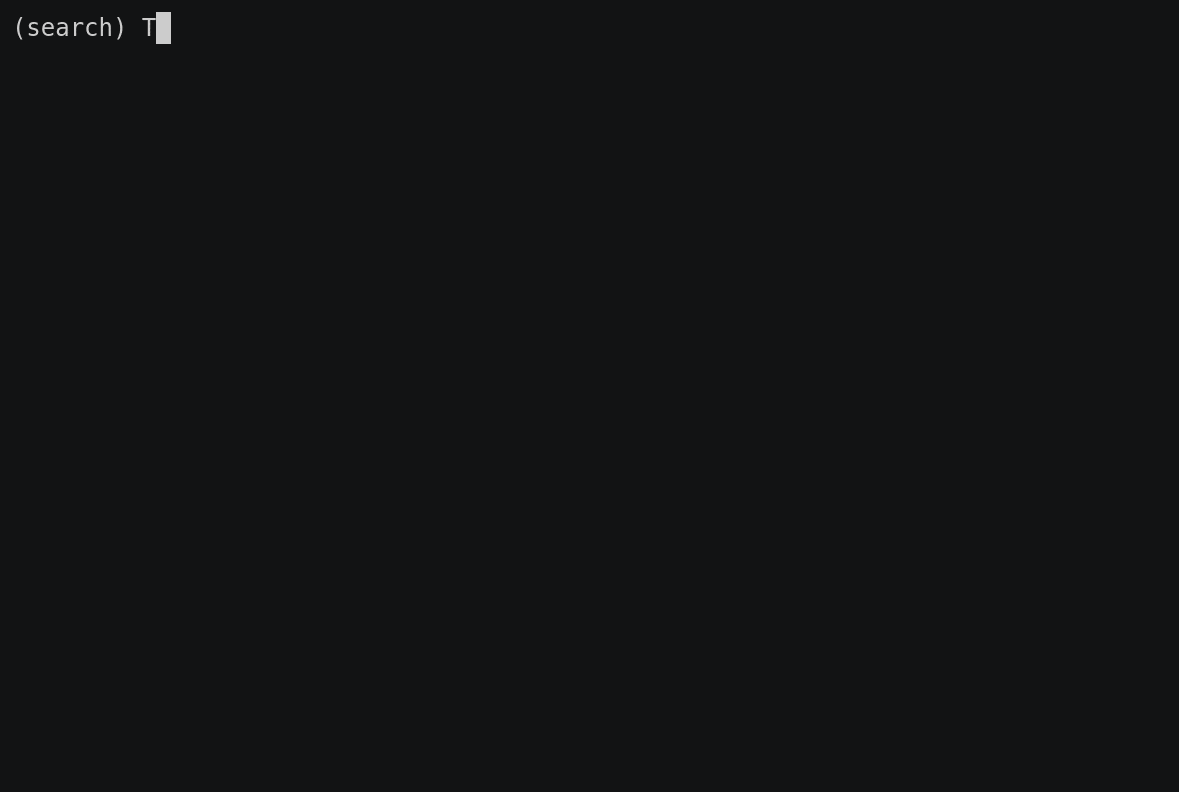

In [ ]:
import urllib

from IPython.display import Image

# Get an image
request = urllib.request.urlopen("https://raw.githubusercontent.com/neuml/txtai/master/demo.gif")

# Upsert new record having both text and an object
embeddings.upsert([("txtai", {"text": "txtai executes machine-learning workflows to transform data and build AI-powered semantic search applications.", "object": request.read()}, None)])

# Query txtai for the most similar result to "machine learning" and get associated object
result = embeddings.search("select object from txtai where similar('machine learning') limit 1")[0]["object"]

# Display image
Image(result.getvalue(), width=600)

# Wrapping up

This notebook gave a quick overview of txtai. This is just scratching the surface on what txtai can do. The following links have much more with examples on how to use embeddings, pipelines, workflows and the API to build semantic search applications. 

- [Documentation for txtai](https://neuml.github.io/txtai)
- [Full list of examples](https://neuml.github.io/txtai/examples/)